# Toxic Comment Classification
**Machine Learning Nanodegree capstone project**  

**Fabio Steffenino**

---

### Load data

In [10]:
import warnings
warnings.filterwarnings('ignore')

import re
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Creating train and test dataframe.

In [11]:
#labels
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#train dataset
train_set = pd.read_csv('train.csv')

#train dataset split
train_comment_set = train_set.drop( toxic_columns, axis=1)
train_comment_set = train_comment_set.drop( ['id'], axis=1)
train_label_set = train_set.drop( ['id','comment_text'], axis=1)

#test dataset 
test_comment_set = pd.read_csv('test.csv')

#test labels for final verification and testing
test_label_set = pd.read_csv('test_labels.csv')


In [12]:
train_set.drop( ['id'], axis=1).head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
train_set.shape

(159571, 8)

In [15]:
test_comment_set.shape

(153164, 2)

In [16]:
print('Training dataset')
print('----------------')
print(train_comment_set[:10])
print('')
print(train_label_set[:10])

Training dataset
----------------
                                        comment_text
0  Explanation\nWhy the edits made under my usern...
1  D'aww! He matches this background colour I'm s...
2  Hey man, I'm really not trying to edit war. It...
3  "\nMore\nI can't make any real suggestions on ...
4  You, sir, are my hero. Any chance you remember...
5  "\n\nCongratulations from me as well, use the ...
6       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7  Your vandalism to the Matt Shirvington article...
8  Sorry if the word 'nonsense' was offensive to ...
9  alignment on this subject and which are contra...

   toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0              0
1      0             0        0       0       0              0
2      0             0        0       0       0              0
3      0             0        0       0       0              0
4      0             0        0       0       0              0
5   

In [17]:
print('Test dataset')
print('----------------')
print(test_comment_set.head())

Test dataset
----------------
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.


In [7]:
print('Training dataset size :', train_set.shape[0])
print('Training dataset column :', train_set.shape[1])
print('Testing dataset size :', test_comment_set.shape[0])
print('Testing dataset column :', test_comment_set.shape[1])
print('Entire corpus size :', train_set.shape[0]+test_comment_set.shape[0])

Training dataset size : 159571
Training dataset column : 8
Testing dataset size : 153164
Testing dataset column : 2
Entire corpus size : 312735


In [21]:
train_set['comment_text'].str.len().describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

In [28]:
train_set.iloc[6]

id                                           0002bcb3da6cb337
comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
Name: 6, dtype: object

In [36]:
train_set['comment_text'][6]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [58]:
train_set['comment_text'][10]

2875

In [37]:
train_set.iloc[290]

id                                                00b9c08a7c708e0a
comment_text     Another question, does this style information ...
toxic                                                            0
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
Name: 290, dtype: object

In [54]:
temp_words = train_set.drop( toxic_columns, axis=1 )
temp_words = temp_words.drop( ['id'], axis=1 )
temp_words['count_word'] = temp_words["comment_text"].apply(lambda x: len(str(x).split()))
temp_words['count_char'] = temp_words["comment_text"].apply(lambda x: len(str(x)))
temp_words.describe()

,count_word,count_char
count,159571.000000,159571.000000
mean,67.273527,394.073221
std,99.230702,590.720282
min,1.000000,6.000000
25%,17.000000,96.000000
50%,36.000000,205.000000
75%,75.000000,435.000000
max,1411.000000,5000.000000


In [44]:
temp_words.head()

,comment_text,count_word
0,Explanation\nWhy the edits made under my usern...,43
1,D'aww! He matches this background colour I'm s...,17
2,"Hey man, I'm really not trying to edit war. It...",42
3,"""\nMore\nI can't make any real suggestions on ...",113
4,"You, sir, are my hero. Any chance you remember...",13


### Printing label statistics

creating a dataset called main_set just for printing some stats and do not affect the original dataset

In [8]:
main_set = train_set.drop(['id'], axis=1)
main_set['not_toxic'] = 1-main_set[toxic_columns].max(axis=1) #tag non toxic comment as not_toxic

In [10]:
main_set[:10]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_toxic
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [11]:
print('Number of toxic comments:', main_set[ main_set['not_toxic']==0 ].shape[0])

Number of toxic comments: 16225


In [12]:
print('Number of pure comments:', main_set[ main_set['not_toxic']==1 ].shape[0])

Number of pure comments: 143346


In [13]:
main_set.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
not_toxic        0
dtype: int64

### Class imbalance

In [14]:
main_set.drop(['comment_text'], axis=1).sum()

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
not_toxic        143346
dtype: int64

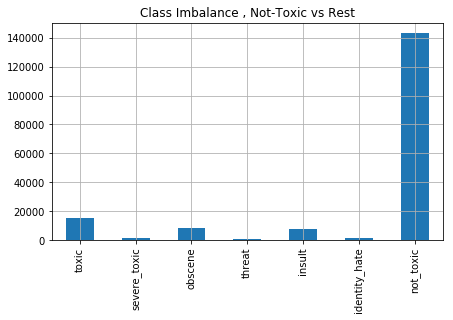

In [26]:
main_set.drop(['comment_text'], axis=1).sum().plot(x='Toxic category', 
                                                   y='Occurrence', 
                                                   kind='bar', 
                                                   figsize=(7, 4),
                                                   title='Class Imbalance , Not-Toxic vs Rest',
                                                   grid=True)

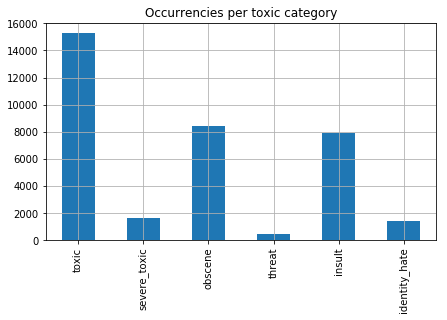

In [28]:
main_set.drop(['comment_text', 'not_toxic'], axis=1).sum().plot(x='Toxic category', 
                                                          y='Occurrence', 
                                                          kind='bar', 
                                                          figsize=(7, 4),
                                                          title='Occurrencies per toxic category',
                                                          grid=True)

### Multi labels rows

creating a dataset called train_label_stat just for printing some stats and do not affect the original dataset

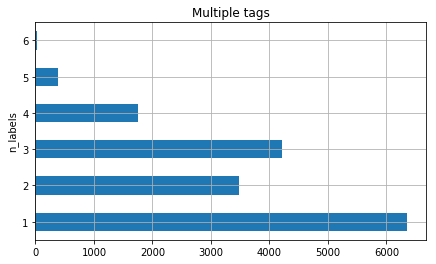

In [29]:
#we get rid of not_toxic for which we already know we have 143346 items (0 labels)
train_label_stat=main_set.drop(['comment_text', 'not_toxic'], axis=1)
train_label_stat['n_labels']=train_label_stat.iloc[:,-6:].sum(axis=1)
train_label_stat['count']=0
train_label_stat=train_label_stat.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)
train_label_stat[train_label_stat['n_labels']>0].groupby(['n_labels'], as_index=False).count().plot.barh(x='n_labels', 
                                                                    y='count',  
                                                                    legend=False,
                                                                    figsize=(7, 4),
                                                                    title='Multiple tags',
                                                                    grid=True)

In [31]:
idx = 0
for lb1 in toxic_columns:
    idx+=1
    for lb2 in toxic_columns[idx:]:
        print(lb1,'and', lb2, '? -> %d' % main_set[(main_set[lb1] > 0) & (main_set[lb2] > 0)].shape[0])

toxic and severe_toxic ? -> 1595
toxic and obscene ? -> 7926
toxic and threat ? -> 449
toxic and insult ? -> 7344
toxic and identity_hate ? -> 1302
severe_toxic and obscene ? -> 1517
severe_toxic and threat ? -> 112
severe_toxic and insult ? -> 1371
severe_toxic and identity_hate ? -> 313
obscene and threat ? -> 301
obscene and insult ? -> 6155
obscene and identity_hate ? -> 1032
threat and insult ? -> 307
threat and identity_hate ? -> 98
insult and identity_hate ? -> 1160


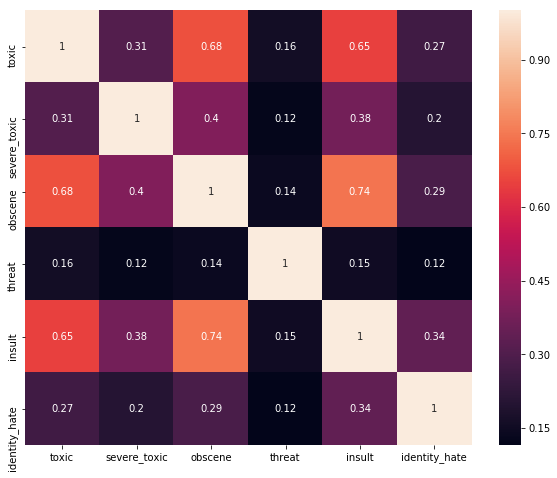

In [18]:
multilabels=train_set.drop( ['id'], axis=1).corr()
plt.figure(figsize=(10,8))
sns.heatmap(multilabels,xticklabels=multilabels.columns.values,yticklabels=multilabels.columns.values, annot=True)

Some observations

Most frequent labels are toxic, obscene and insult. They seem to be the major categories.
Toxic and severe_toxic label are related while all other labels seem to be independent

### Clean comment field

In [32]:
test_comment_set['comment_text'].fillna(value='none', inplace=True)
train_comment_set['comment_text'].fillna(value='none', inplace=True)

In [33]:
#clean and remove stopwords
stop_words = set(stopwords.words('english'))
def normalize_text(text):
    text = text.lower() 
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub("[^a-z]", " ", text)
    text = text.strip(' ')
    for word in stop_words: #removing stopwords
        token = " " + word + " "
        text = text.replace(token, " ")
        text = text.replace("  ", " ")
    return text

train_comment_set['comment_text'] = train_comment_set['comment_text'].map(lambda el : normalize_text(el))
test_comment_set['comment_text'] = test_comment_set['comment_text'].map(lambda el : normalize_text(el))

In [34]:
train_comment_set['comment_text'][3]

'more make real suggestions improvement wondered section statistics later subsection types accidents think references may need tidying exact format ie date format etc later one else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns listed relevant form eg wikipedia good article nominations transport'

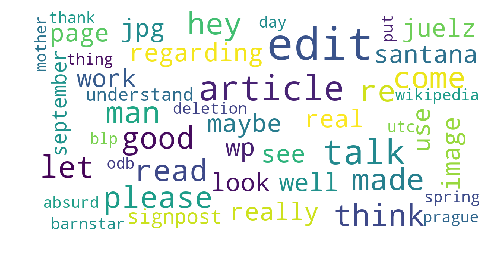

In [35]:
stopwordswc = set(STOPWORDS)
def show_wordcloud(data, back = 'white', title = None, max_word = 45):
    wordcloud = WordCloud(
        background_color=back,
        stopwords=stopwordswc,
        max_words=max_word,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(train_comment_set['comment_text'])

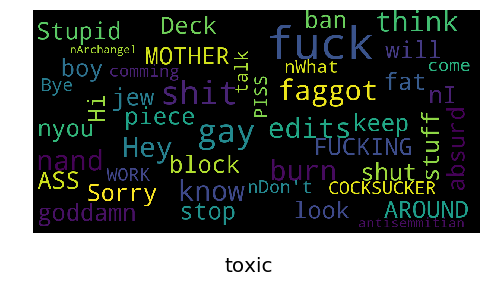

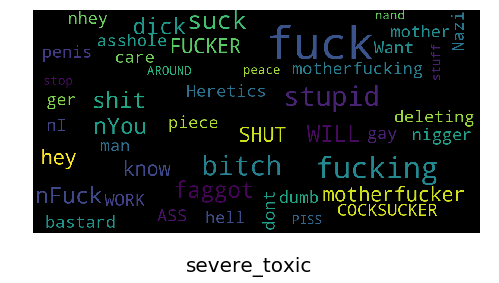

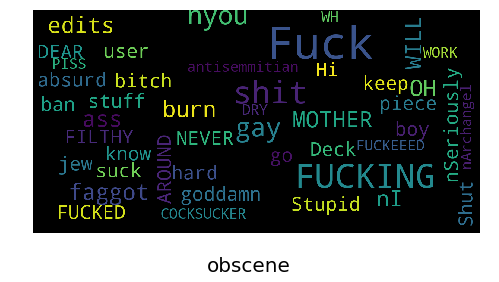

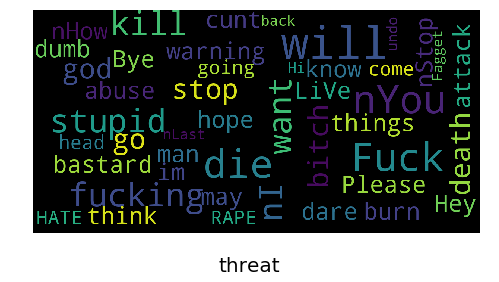

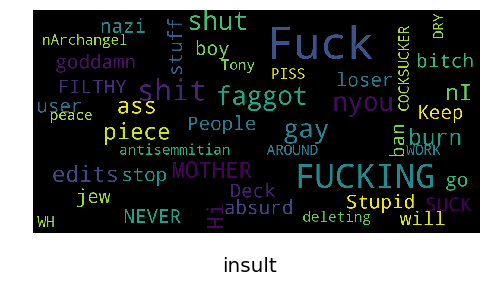

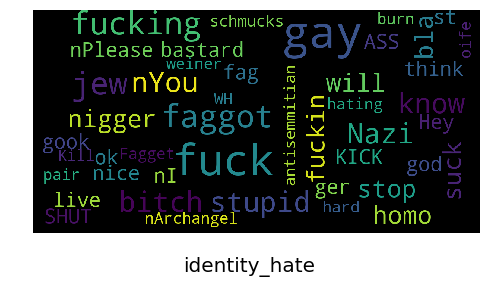

In [36]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for lb in labels:
    train_temp=train_set[train_set[lb]==1]
    show_wordcloud(train_temp['comment_text'],'black',lb)


### TF-IDF vectorization and feature extraction
  
Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.  

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [38]:
corpus = pd.concat([train_comment_set['comment_text'],test_comment_set['comment_text']]).reset_index(drop=True)
corpus[:10]

0    explanation edits made username hardcore metal...
1    d aww matches background colour seemingly stuc...
2    hey man really trying edit war guy constantly ...
3    more make real suggestions improvement wondere...
4                 you sir hero chance remember page on
5             congratulations well use tools well talk
6                          cocksucker piss around work
7    your vandalism matt shirvington article revert...
8    sorry word nonsense offensive anyway intending...
9                 alignment subject contrary dulithgow
Name: comment_text, dtype: object

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( analyzer='word', strip_accents='unicode', stop_words='english', sublinear_tf=True,
                              ngram_range=(1, 1), max_df = 50000, max_features=500)
vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=50000, max_features=500,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [83]:
train_text_transf =  vectorizer.transform(train_comment_set['comment_text'])

In [84]:
features_extract = np.array(vectorizer.get_feature_names())

extract top 10 words per category

In [90]:
top_per_class = []

top_n = 10 # get top n words
min_val = 0.1 # min tfidf value to be considered
for col in toxic_columns:
    #indexes of comments of a given label class
    ids = train_set.index[train_set[col]==1]
    #array of words in comments of a given label class
    text_array = train_text_transf[ids].toarray()
    text_array[ text_array < min_val ] = 0
    tfidf_means = np.mean(text_array, axis=0)
    #sort to get top 10
    topn_ids = np.argsort(tfidf_means)[::-1][:top_n]
    top_feats = [(features_extract[i], tfidf_means[i]) for i in topn_ids]
    #create a dataframe with top words and correspondent tfidf value
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf_value']
    feats_df = df
    feats_df.label = cols
    top_per_class.append(feats_df)

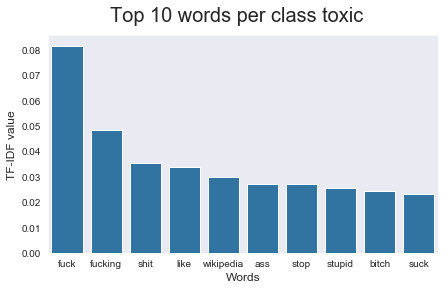

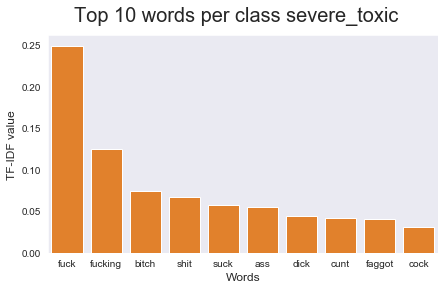

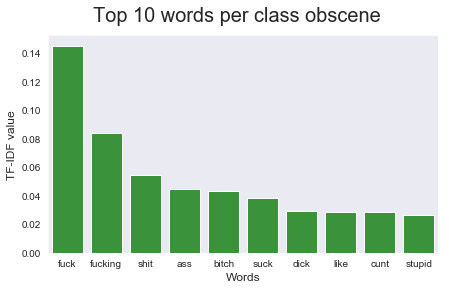

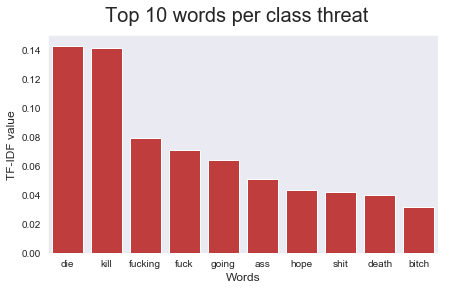

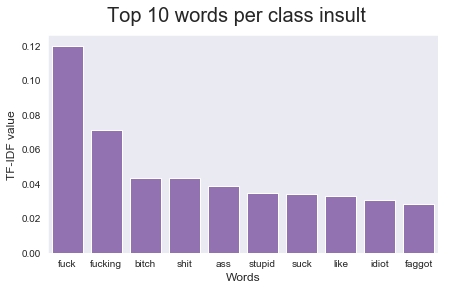

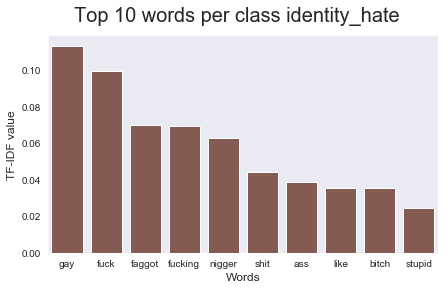

In [91]:
i = 0
color = sns.color_palette()
for clas in toxic_columns:
    fig = plt.figure(figsize=(7,4))
    fig.suptitle("Top 10 words per class "+clas,fontsize=20)
    sns.barplot(top_per_class[i].feature,top_per_class[i].tfidf_value,color=color[i])
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('TF-IDF value', fontsize=12)
    plt.show()
    i= i+1